In [1]:
from pdbfixer import PDBFixer
import simtk.openmm as mm
from simtk.openmm.app import PDBFile, Modeller, ForceField

import nglview as nv
import numpy as np
from matplotlib import pyplot as plt

## Fixing the pdb file of Estrogen receptor

In [2]:
receptor_file = "../1_system_inspection/receptor_1.pdb"
view = nv.show_structure_file(receptor_file)
view

NGLWidget()

In [3]:
# First load the file 
fixer = PDBFixer(filename=receptor_file)
type(fixer)

pdbfixer.pdbfixer.PDBFixer

In [4]:
fixer.findMissingResidues()
missing_residues = fixer.missingResidues
print(f"{len(missing_residues)} missing residues")

fixer.findNonstandardResidues()
nonstandard_residues = fixer.nonstandardResidues
print(f"{len(missing_residues)} non standard residues")

fixer.findMissingAtoms()
missing_atoms = fixer.missingAtoms
missing_terminals = fixer.missingTerminals
print(f"{len(missing_atoms)} missing atoms")
print(f"{len(missing_terminals)} missing terminals")
fixer.addMissingAtoms()

0 missing residues
0 non standard residues
3 missing atoms
0 missing terminals


<div class="alert alert-warning">
<strong>Flexible or rigid water?</strong> TIP3P is not a good water model, but many forcefields were parametrized with it. Having the flexible version (TIP3PFB) of the model in our simulations will not improve them enough to compensate the computational cost. At this moment, let's work with rigid waters (TIP3P). Do you know any other water model? Why there are so many models? What does the number '3' means in TIP3P? See <a href="http://www.sklogwiki.org/SklogWiki/index.php/Water_models">this web</a> or <a href="http://www.lsbu.ac.uk/water/models.html">this other web</a>.
</div>

In [5]:
forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml') #changed to tip3p

In [8]:
counter = {'HIP':[], 'HIE':[], 'HID':[]}
pHs = np.linspace(1, 14, 20)

for pH in pHs:
    for residue in counter:
        counter[residue].append(0)
    modeller = Modeller(fixer.topology, fixer.positions)
    residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)
    for residue in residues_protonated:
        if residue is not None:
            counter[residue][-1]+=1

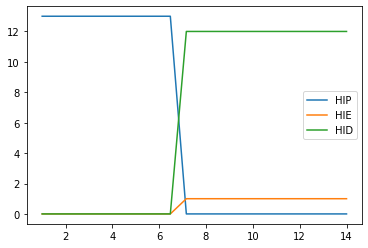

In [9]:
for residue in counter:
    plt.plot(pHs, counter[residue], label=residue)

plt.legend()
plt.show()

<div class="alert alert-warning">
<strong>Is the protonated states something stationary along the simulation?</strong> The protonation state of certain residues depends on their chemical environment. We have here inferred how the histidine residues are protonated at different pHs. But: will this states change along the simulation? How can we define these states without ions and water molecules? Is the chemical environment of a given residue something that will change in time? If the protonated residues can change their state near pH 7, are we worried?
</div>

In [14]:
modeller = Modeller(fixer.topology, fixer.positions)

pH = 7.2
residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)

<div class="alert alert-warning">
<strong>What value of pH should you use?</strong> Are you interested in a simulation of the receptor in pure water? in the cytoplasm? in the nucleous? Is the pH different? Is it relevant?
</div>

In [16]:
# Vectors to define the octahedron
vectors = mm.Vec3(1,0,0), mm.Vec3(1/3,2*np.sqrt(2)/3,0), mm.Vec3(-1/3,np.sqrt(2)/3,np.sqrt(6)/3)
# boxVectors = [(maxSize+geompadding)*v for v in vectors]
modeller.addSolvent(forcefield=forcefield, model="tip3p", boxVectors=vectors, neutralize=False)

In [17]:
PDBFile.writeFile(modeller.topology, modeller.positions, open('fixed_receptor.pdb', 'w'))

In [18]:
n_waters = 0
for chain in modeller.topology.chains():
    for residue in chain.residues():
        if residue.name=='HOH':
            n_waters += 1

print('n_waters: {}'.format(n_waters))

n_waters: 0


<div class="alert alert-danger">
<strong>Did you check that your final system had water molecules?</strong> 
</div>

In [19]:
modeller = Modeller(fixer.topology, fixer.positions)

pH = 7.2

residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)

In [21]:
import openmm as mm
from openmm import app
from openmm import unit

In [28]:
# Lets create a system with the protein in vacuum (infinite space) to get the charge

system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff)

In [32]:
system.getNumParticles()

4058

In [37]:
charge = 0.0 * unit.elementary_charge
for force_index in range(system.getNumForces()):
    force = system.getForce(force_index)
    if isinstance(force, mm.NonbondedForce):
        for index in range(system.getNumParticles()):
            charge+=force.getParticleParameters(int(index))[0]

charge = np.round(charge._value)*charge.unit

In [38]:
charge

Quantity(value=-4.0, unit=elementary charge)

<div class="alert alert-warning">
<strong>The system is charged.</strong> The system is charged and the simulation box should be neutral to work easy with the electrostatic interaction terms. We have to add ions then. Where are the charges? Is there any charge near the binding site? Did we add charge to the terminals? Should we work with neutral terminal cappings like the chemical groups acetyl (ACE) and n-methyl amide (NME)?
</div>

In [43]:
max_size = max(max((pos[i] for pos in modeller.positions))-min((pos[i] for pos in modeller.positions)) for i in range(3))
vectors = mm.Vec3(1.0, 0, 0), mm.Vec3(1.0/3.0, 2.0*np.sqrt(2.0)/3.0,0.0), mm.Vec3(-1.0/3.0, np.sqrt(2.0)/3.0, np.sqrt(6.0)/3.0)
box_vectors = [(max_size+14*unit.angstroms)*v for v in vectors]

modeller.addSolvent(forcefield, model='tip3p', boxVectors = box_vectors, neutralize=True)

In [44]:
n_waters = 0
for chain in modeller.topology.chains():
    for residue in chain.residues():
        if residue.name=='HOH':
            n_waters += 1

print('n_waters: {}'.format(n_waters))

n_waters: 7794


In [50]:
n_ions = 0
for chain in modeller.topology.chains():
    for residue in chain.residues():
        if residue.name=='NA':
            n_ions += 1

print('n_ions: {}'.format(n_ions))

n_ions: 4
